In [1]:
import librosa
import numpy as np

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
print(tf.test.is_gpu_available())

import matplotlib.pyplot as plt
import numpy as np

In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2

2.0.0
True


# config

In [2]:
# mel-spectrogram parameters
SR = 12000
N_FFT = 512
N_MELS = 96
HOP_LEN = 256
n_sample_fit = 60672
N_FRAME = 238

data_path = '/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/audio/audio'
train_path = data_path + '/train/*/*'
test_path = data_path + '/test/*/*'
val_path = data_path + '/validation/*/*'

class_names = ['sick', 'not_sick']
batch_size = 4
train_samples = 1434 + 2282
steps_per_epoch = train_samples // batch_size
steps_per_epoch

929

In [3]:
def stats(t):
    s = 'mean:'
    s += str(t.mean())
    s += ' max:'
    s += str(t.max())
    s += ' min:'
    s += str(t.min())
    s += ' median:'
    s += str(np.median(t))
    s += ' std:'
    s += str(t.std())
    s += ' shape:'
    s += str(t.shape)
    s += ' dtype:'
    s += str(t.dtype)
    print(s)

In [4]:
def compute_melgram(audio_path):
    ''' Compute a mel-spectrogram and returns it in a shape of (1,1,96,1366), where
    96 == #mel-bins and 1366 == #time frame
    parameters
    ----------
    audio_path: path for the audio file.
                Any format supported by audioread will work.
    More info: http://librosa.github.io/librosa/generated/librosa.core.load.html#librosa.core.load
    '''

    src, sr = librosa.load(audio_path, sr=SR)  # whole signal
    n_sample = len(src)
    if n_sample < n_sample_fit:  # if too short
        src = np.hstack((src, np.zeros(n_sample_fit - n_sample, dtype=np.float32)))
    elif n_sample > n_sample_fit:  # if too long
        src = src[(n_sample-n_sample_fit)/2:(n_sample+n_sample_fit)/2]
#     stats(src)


    spec = librosa.feature.melspectrogram(y=src, sr=SR, hop_length=HOP_LEN, n_fft=N_FFT, n_mels=N_MELS)
#     stats(spec)

    ret = librosa.amplitude_to_db(spec)
    ret = (ret-ret.min())/(ret.max()-ret.min() + 1e-5)

    ret = ret[..., np.newaxis]
    return ret

def plot_mel(ret):
    plt.figure()
    plt.pcolormesh(ret)
    plt.colorbar()
    plt.show()

mean:0.021758145 max:0.9999999 min:0.0 median:0.0 std:0.08211287 shape:(96, 238, 1) dtype:float32


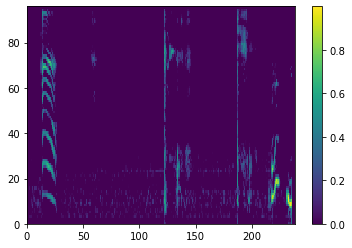

In [5]:
ret = compute_melgram('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/audio/audio/test/sick/audioset_0-8Ht8OvuII_30_35.wav')
stats(ret)
plot_mel(ret[..., 0])

In [6]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    one_hot = tf.cast(one_hot, tf.int64)
    # Integer encode the label
    return tf.argmax(one_hot)
# get_label('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/continuous_wavelet_transform/continuous_wavelet_transform/train/sick/audioset_0CroKP1sYVw_10_15.jpg')

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = compute_melgram(bytes.decode(file_path.numpy()))
    return img, label
# img, label = process_path('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/audio/audio/test/sick/audioset_aiojV7s3hv0_55_60.wav')
# stats(img)
# label

def set_dataset_shape(mel, label):
    mel = tf.reshape(mel, [-1, N_MELS, N_FRAME, 1])
    label = tf.reshape(label, (-1, ))
    return mel, label

def get_dataset(path, name):
    ds = tf.data.Dataset.list_files(path)
    ds = ds.map(lambda x: tf.py_function(process_path, [x], [tf.float32, tf.int64]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache(name).shuffle(buffer_size=100).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    ds = ds.map(set_dataset_shape)
    return ds


In [7]:
train_ds = get_dataset(train_path, 'audio_train_catch')
test_ds = get_dataset(test_path, 'audio_test_catch')
val_ds = get_dataset(val_path, 'audio_val_catch')
print(test_ds)
for img, label in val_ds.take(1):
    stats(img.numpy())
    print(label)

<DatasetV1Adapter shapes: ((None, 96, 238, 1), (None,)), types: (tf.float32, tf.int64)>
mean:0.038310666 max:0.9999999 min:0.0 median:0.0 std:0.12028779 shape:(4, 96, 238, 1) dtype:float32
tf.Tensor([1 1 1 0], shape=(4,), dtype=int64)


# model

In [66]:
def cnn_block(model, num_filters, pool_size, layer_id):
    model.add(layers.Conv2D(num_filters, [6, 6], padding='same', name=f'conv{layer_id}'))
    model.add(layers.BatchNormalization(axis=-1, name=f'bn{layer_id}'))
    model.add(layers.ELU(name=f'elu{layer_id}'))
    model.add(layers.MaxPool2D(pool_size, name=f'pool{layer_id}'))
    model.add(layers.Dropout(0.1, name=f'dropout{layer_id}'))
    return model

def music_crnn(input_shape):
    model = tf.keras.Sequential()

    model.add(layers.ZeroPadding2D((0, 1), input_shape=input_shape))#(96, 236, 1)
    model = cnn_block(model, 64, (2,2), 1)
    model = cnn_block(model, 128, (2,2), 2)
    model = cnn_block(model, 128, (2,2), 3)
    model = cnn_block(model, 128, (2,2), 4)
#     model = cnn_block(model, 128, (2,2), 5)
#     model = cnn_block(model, 128, (2,2), 6)
    
    model.add(layers.Permute((2, 1, 3)))

    model.add(layers.Reshape((15, 6*128)))
#     model.add(layers.GRU(64, return_sequences=True, name='gru1'))
    model.add(layers.GRU(32, return_sequences=False, name='gru2'))
#     model.add(layers.Dropout(0.3, name=f'dropout5'))
#     model.add(layers.Flatten())

    model.add(layers.Dense(1, name='output'))

    model.summary()
    return model
model = music_crnn((96, 238, 1))

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_29 (ZeroPaddi (None, 96, 240, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 240, 64)       2368      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 96, 240, 64)       256       
_________________________________________________________________
elu1 (ELU)                   (None, 96, 240, 64)       0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 120, 64)       0         
_________________________________________________________________
dropout1 (Dropout)           (None, 48, 120, 64)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 120, 128)    

In [ ]:
def cnn_block(model, num_filters, pool_size, layer_id):
    model.add(layers.Conv2D(num_filters, 3, padding='same', name=f'conv{layer_id}'))
    model.add(layers.BatchNormalization(axis=-1, name=f'bn{layer_id}'))
    model.add(layers.ELU(name=f'elu{layer_id}'))
    model.add(layers.MaxPool2D(pool_size, name=f'pool{layer_id}'))
    model.add(layers.Dropout(0.1, name=f'dropout{layer_id}'))
    return model

def music_crnn(input_shape):
    model = tf.keras.Sequential()

    model.add(layers.ZeroPadding2D((0, 37), input_shape=input_shape))#(96, 236, 1)
    model = cnn_block(model, 64, (3,3), 1)
    model = cnn_block(model, 128, (2,2), 2)
    model = cnn_block(model, 128, (4,4), 3)
    model = cnn_block(model, 128,Reshape((6*15, 128)))
#     model.add(layers.GRU(64, return_sequences=True, name='gru1'))
#     model.add(layers.GRU(32, return_sequences=False, name='gru2'))
#     model.add(layers.Dropout( (4,4), 4)

    model.add(layers.Reshape((3, 128)))
    model.add(layers.GRU(64, return_sequences=True, name='gru1'))
    model.add(layers.GRU(32, return_sequences=False, name='gru2'))
    model.add(layers.Dropout(0.3, name=f'dropout5'))
#     model.add(layers.Flatten())

    model.add(layers.Dense(1, name='output'))

    model.summary()
    return model
model = music_crnn((96, 238, 1))

In [67]:
learning_rate = 0.001
save_dir = './rcnn/'
log_dir = save_dir + 'logs/'
checkpoint_dir = save_dir + 'checkpoints/'

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    learning_rate,
    decay_steps=steps_per_epoch*5,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(lr_schedule)

callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.TensorBoard(log_dir),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                            monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                            save_weights_only=True)
    ]

In [68]:
epochs = 100

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/100
    929/Unknown - 25s 27ms/step - loss: 0.6100 - accuracy: 0.6292
Epoch 00001: val_accuracy improved from -inf to 0.66776, saving model to ./rcnn/checkpoints/
929/929 [==============================] - 28s 31ms/step - loss: 0.6100 - accuracy: 0.6292 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
927/929 [============================>.] - ETA: 0s - loss: 0.5582 - accuracy: 0.6753
Epoch 00002: val_accuracy improved from 0.66776 to 0.72190, saving model to ./rcnn/checkpoints/
929/929 [==============================] - 26s 28ms/step - loss: 0.5583 - accuracy: 0.6755 - val_loss: 0.5300 - val_accuracy: 0.7219
Epoch 3/100
926/929 [============================>.] - ETA: 0s - loss: 0.5174 - accuracy: 0.7184
Epoch 00003: val_accuracy improved from 0.72190 to 0.73749, saving model to ./rcnn/checkpoints/
929/929 [==============================] - 26s 28ms/step - loss: 0.5169 - accuracy: 0.7193 - val_loss: 0.5134 - val_accuracy: 0.7375
Epoch 4/100
928/929 [===============

In [70]:
model.load_weights(checkpoint_dir)
model.evaluate(test_ds)

413/413 [==============================] - 4s 10ms/step - loss: 0.4429 - accuracy: 0.8172


[0.44290850566785794, 0.8171913]